In [2]:
try:
    import cPickle as pickle
except ModuleNotFoundError:
    import pickle
from kaveh.behavioral.oculomotor.target import target
from kaveh.sorting import spikesorter
from kaveh.toolbox import find_file
import numpy as np
from matplotlib import pyplot as plt
from smr import File
import csv
import os
from neo.io import Spike2IO


In [3]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [4]:
raw_files_with_8_dir_exp = []
num_clust = []
with open('/mnt/data/temp/kaveh/2010_Adapt.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        if(row[1] == '*'):
            path, filename = os.path.split(row[0])
            f_name = find_file(filename[:-4], '/mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2010_Adapt/')
            raw_files_with_8_dir_exp = raw_files_with_8_dir_exp + [f_name]
#             num_clust = num_clust + [int(row[2])]
            

In [5]:
neo_reader = Spike2IO(filename=raw_files_with_8_dir_exp[5])
seg = neo_reader.read_segment()

In [6]:
analog_sigs = seg.analogsignals

In [7]:
asig = analog_sigs[0]

for asig in analog_sigs:
#     print(asig.annotations['channel_names'], asig.annotations['channel_ids'])
    if asig.annotations['channel_ids'][0] == 1:
        print('HE: ', asig.annotations['channel_names'][0])
        he_pos = asig.magnitude
        he_dt = asig.sampling_period.magnitude
    if asig.annotations['channel_ids'][0] == 2:
        print('VE: ', asig.annotations['channel_names'][0])
        ve_pos = asig.magnitude
        ve_dt = asig.sampling_period.magnitude
    if asig.annotations['channel_ids'][0] == 3:
        print('HT: ', asig.annotations['channel_names'][0])
        ht_pos = asig.magnitude
        ht_dt = asig.sampling_period.magnitude
    if asig.annotations['channel_ids'][0] == 4:
        print('VE: ', asig.annotations['channel_names'][0])
        vt_pos = asig.magnitude
        vt_dt = asig.sampling_period.magnitude

('HE: ', u'HE')
('VE: ', u'VE')
('HT: ', u'HT')
('VE: ', u'VT')


In [8]:
tt = target(np.squeeze(vt_pos), np.squeeze(ht_pos), float(vt_dt), '2d')

In [9]:
tjs = tt._find_target_jumps_2d()

In [10]:
raw_files_with_8_dir_exp[5]

'/mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2010_Adapt/Felix/F101106/F101106_1311_List.smr'

In [11]:
ve_v = np.diff(ve_pos, axis=0)/ve_dt
he_v = np.diff(he_pos, axis=0)/he_dt



In [12]:
(1.0 / (2.0 * ve_dt))

500.0

In [13]:
from scipy import signal
cutoff_freq = 100.0
filter_order = 3

b, a = signal.butter(filter_order, cutoff_freq / (1.0 / (2.0 * ve_dt)), 'low')
ve_v_filtered = signal.filtfilt(b, a, ve_v, axis=0)
b, a = signal.butter(filter_order, cutoff_freq / (1.0 / (2.0 * he_dt)), 'low')
he_v_filtered = signal.filtfilt(b, a, he_v, axis=0)

In [14]:
e_v = np.linalg.norm(np.vstack((ve_v, he_v)), axis = 1)
e_v_filtered = np.linalg.norm(np.vstack((ve_v_filtered, he_v_filtered)), axis = 1)

In [15]:
from scipy.signal import savgol_filter
e_v_sg = savgol_filter(e_v_filtered, 31,9)

<IPython.core.display.Javascript object>


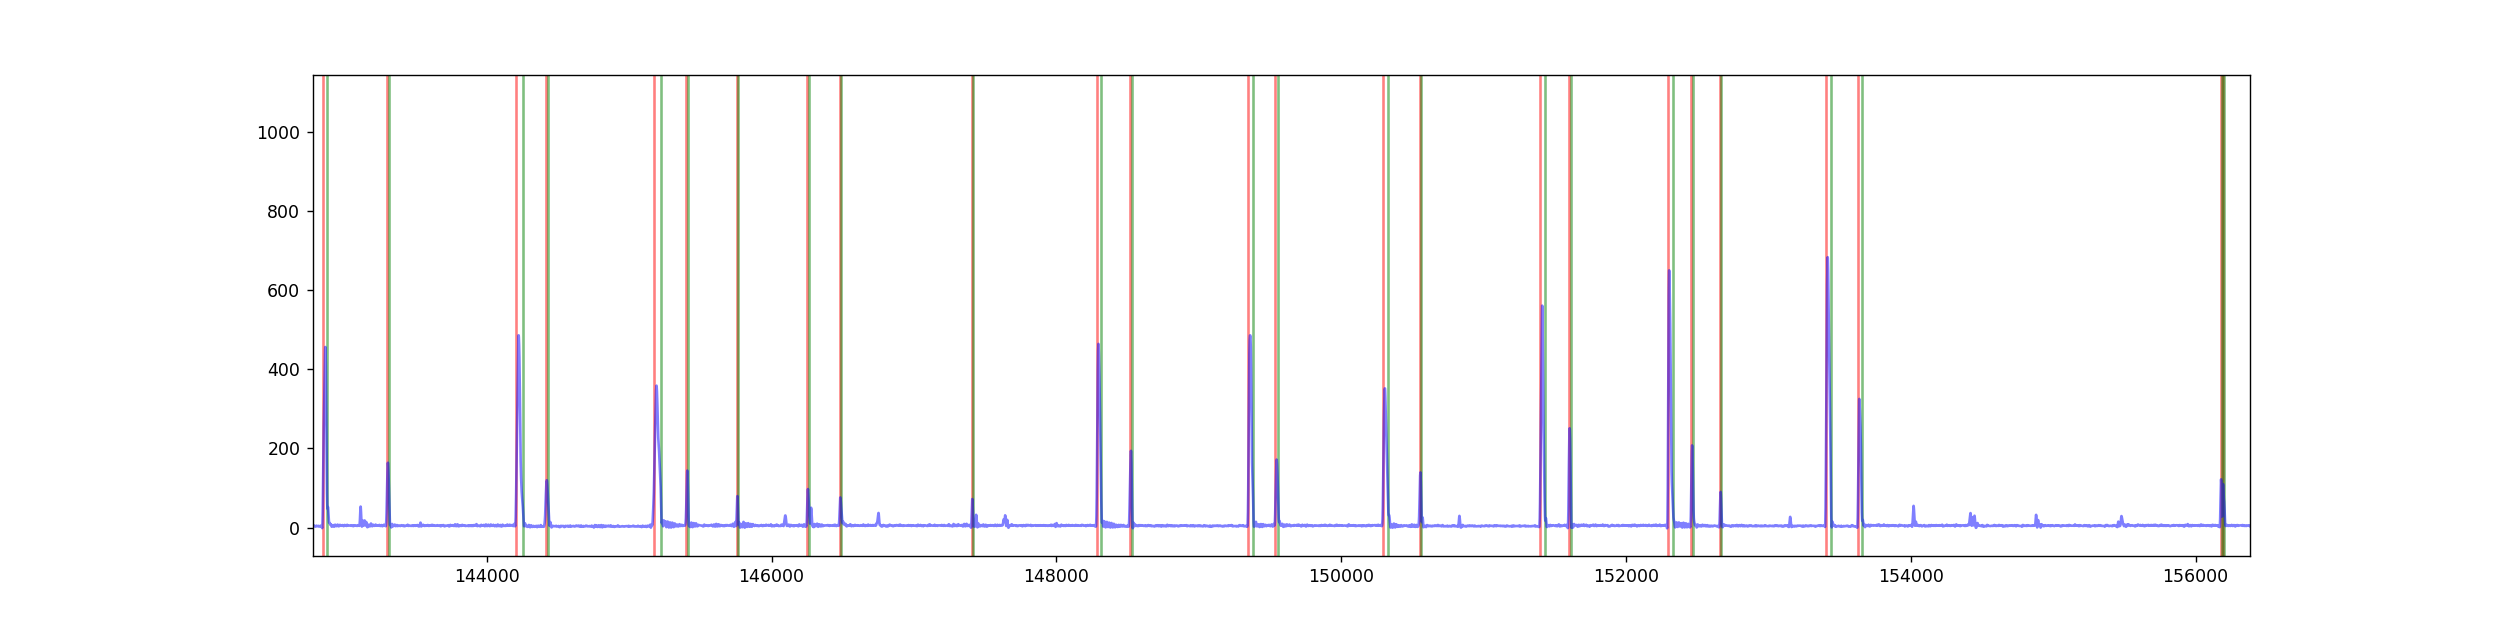

In [23]:
plt.figure(figsize=(20, 5))
# plt.plot(e_v, alpha = 0.4)
# plt.plot(e_v_filtered[0:1000], alpha = 0.5)
plt.plot(e_v_sg,'b', alpha = 0.5)

# plt.plot(np.diff(e_v_filtered), alpha = 0.5)

In [24]:
thresh = 60 # deg/s
rising = e_v_sg > thresh
rising[1:][rising[1:] & rising[:-1]] = False

falling = e_v_sg > thresh
falling[:-1][falling[1:] & falling[:-1]] = False

from kaveh.plots import axvlines

rising = np.where(rising == True)
falling = np.where(falling == True)

axvlines(plt.gca(), rising[0], color = 'r', alpha = 0.5)
axvlines(plt.gca(), falling[0], color = 'g', alpha = 0.5)